In [136]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg
from pandas import DataFrame
from statsmodels.tsa.arima.model import ARIMA
import copy
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Step 1: Preparing the Data
#### First, we'll load the data and prepare it for time series analysis by setting the index to the datetime format.

In [137]:
CP = pd.read_csv('Coal Power.csv')
CP.rename(
    columns={"Unnamed: 0":"date",
                "Total consumption : Texas : electric power (total) : quarterly (short tons)":"power"}
          ,inplace=True)
CP["date"] = CP["date"].str.replace("Q1","01") 
CP["date"] = CP["date"].str.replace("Q2","04") 
CP["date"] = CP["date"].str.replace("Q3","07") 
CP["date"] = CP["date"].str.replace("Q4","10") 
print(CP.head(10))
CP['date'] = pd.to_datetime(CP['date'], utc=False)
CP.set_index('date', inplace = True)
print(CP.head())
CP.info()

       date     power
0  2001 01   22164839
1  2001 04   22952510
2  2001 07   25962808
3  2001 10   21357650
4  2002 01   21917084
5  2002 04   23929655
6  2002 07   26277274
7  2002 10   23548673
8  2003 01   23284033
9  2003 04   24767874
               power
date                
2001-01-01  22164839
2001-04-01  22952510
2001-07-01  25962808
2001-10-01  21357650
2002-01-01  21917084
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 80 entries, 2001-01-01 to 2020-10-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   power   80 non-null     int64
dtypes: int64(1)
memory usage: 1.2 KB


/var/folders/tn/j_7h3t0s1wn4z71_wt0rx9_c0000gn/T/ipykernel_53875/3112737508.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  CP['date'] = pd.to_datetime(CP['date'], utc=False)


### Step 2: Visualizing the Data
#### We'll plot the data to get a visual understanding of the trends and seasonality.

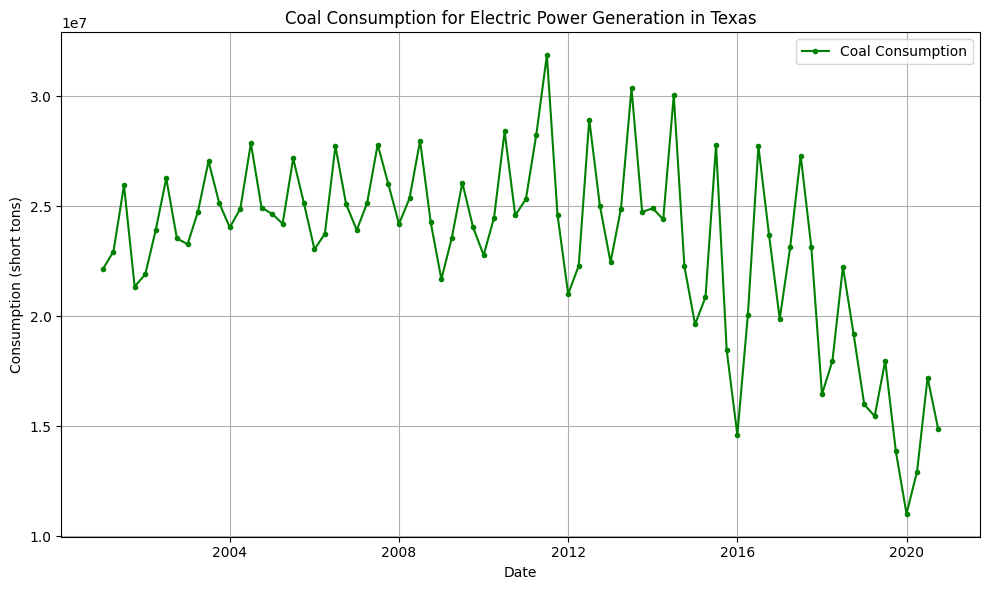

In [138]:
plt.figure(figsize=(10, 6))  
plt.plot(CP.index, CP['power'], label='Coal Consumption', color='green', marker='.', linestyle='-')
plt.title('Coal Consumption for Electric Power Generation in Texas')  
plt.xlabel('Date')  
plt.ylabel('Consumption (short tons)')  
plt.legend()  
plt.grid(True) 
plt.tight_layout()  
plt.show() 

#### The time series plot of coal consumption for electric power generation in Texas indicates:

##### Strong Seasonality: There are consistent seasonal peaks and troughs each year, suggesting higher coal use in some seasons (End of Summers), likely due to temperature-related energy demand.
##### Sharp Fluctuations: The data shows sharp rises and falls in coal consumption, which could reflect changes in demand or supply conditions.
##### Decline After 2018: A noticeable reduction in coal consumption begins around 2018, implying a possible shift away from coal or improvements in energy efficiency.
##### Non-Stationary Series: The regular pattern of seasonal fluctuations points to non-stationarity, meaning the data's statistical properties change over time.
##### Clean Data: The absence of significant outliers suggests the data is consistent and accurately recorded.
##### Overall, the plot reveals predictable seasonal patterns with a recent trend towards lower coal consumption, indicating changes in the energy sector or efficiency gains. This seasonality and recent decline are critical for planning and policy-making in the energy industry.

### Step 3: Checking for Stationarity
#### As we can see from the plot, the regular pattern of seasonal fluctuations points to non-stationarity, here we'll apply the Augmented Dickey-Fuller (ADF) test to check if the series is stationary.

In [139]:
result_CP = adfuller(CP)
print('CP', '\n',result_CP)

CP 
 (1.976302909694134, 0.9986413567364828, 10, 69, {'1%': -3.528889992207215, '5%': -2.9044395987933362, '10%': -2.589655654274312}, 2117.1250184879855)


In [140]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    adf_test = adfuller(timeseries, autolag='AIC')  # AIC is used to select the best lag length

    adf_output = pd.Series(adf_test[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in adf_test[4].items():
        adf_output['Critical Value (%s)' % key] = value

    print(adf_output)

In [141]:
adf_test(CP['power'])

Results of Dickey-Fuller Test:
Test Statistic                  1.976303
p-value                         0.998641
#Lags Used                     10.000000
Number of Observations Used    69.000000
Critical Value (1%)            -3.528890
Critical Value (5%)            -2.904440
Critical Value (10%)           -2.589656
dtype: float64


##### Since the test statistic of 1.976303 is significantly larger than any of the critical values and the p-value is close to 1, we fail to reject the null hypothesis. This indicates that there is not enough statistical evidence to conclude that the time series is stationary. In practical terms, it suggests that the coal consumption time series likely contains a unit root and is non-stationary, meaning that it has properties like mean and variance that change over time.


#### Given the non-stationarity, it's necessary to transform the time series data (e.g., through differencing) before fitting a time series model for forecasting.

### Differencing

In [142]:
CP_copy = copy.deepcopy(CP)
CP_diff = np.diff(cp_copy.power, n=1)

In [143]:
new_index = CP.index[1:] 

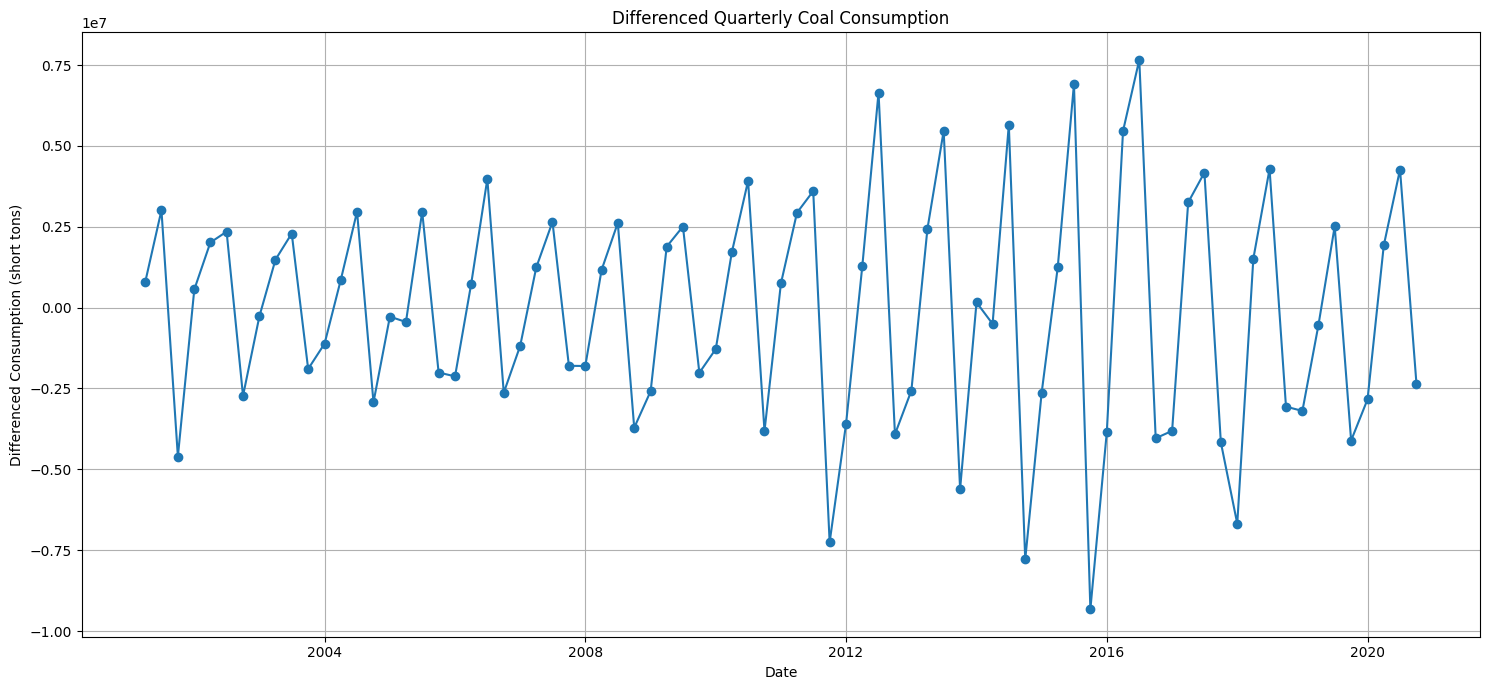

In [144]:
plt.figure(figsize=(15, 7))
plt.plot(new_index, CP_diff, marker='o', linestyle='-')
plt.title('Differenced Quarterly Coal Consumption')
plt.xlabel('Date')
plt.ylabel('Differenced Consumption (short tons)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [145]:
result_CP_diff= adfuller(CP_diff)
print('CP with differencing', '\n',result_CP_diff)

CP with differencing 
 (-4.510983475470282, 0.00018784663168900943, 5, 73, {'1%': -3.5232835753964475, '5%': -2.902030597326081, '10%': -2.5883710883843123}, 2087.3684260623113)


#### The results from the Augmented Dickey-Fuller (ADF) test on the differenced time series data (CP with differencing) indicate the following:

Test Statistic (-4.51): The value of the test statistic is -4.510983475470282. Since this value is less than the critical values at 1%, 5%, and 10% significance levels, we can reject the null hypothesis that there is a unit root present in the series. This suggests that the differenced series is stationary.

p-value (0.00018): The p-value is extremely low, far below the typical threshold of 0.05, indicating strong evidence against the null hypothesis. This reinforces the conclusion that the series does not have a unit root and is stationary.

#Lags Used (5): This indicates that the test used 5 lagged differences of the series to account for serial correlation when determining the test statistic.

Number of Observations Used (73): After accounting for the lags, 73 observations were used in the test. This is the effective sample size for the test.

Critical Values:
1%: -3.523: For a confidence level of 99%, the critical value is -3.523. Since the test statistic is less than this value, we can reject the null hypothesis with more than 99% confidence.
5%: -2.902: For a confidence level of 95%, the critical value is -2.902. The test statistic is also below this threshold, further supporting the rejection of the null hypothesis.
10%: -2.588: For a confidence level of 90%, the critical value is -2.588. Again, the test statistic being lower means the null hypothesis can be rejected at this level as well.
Maximized Information Criterion (2087.368): This value is related to the selection of the lag length in the ADF test model. It's not directly relevant to the interpretation of stationarity but is more about the efficiency of the test execution.


### Moving Average

In [146]:
for i in range(1,50):
  CPbest = CP['power'].rolling(window=i).mean()
  CPbest.dropna(inplace = True)
  CPbest_dataframe = pd.DataFrame(CPbest)
  CPbest_values = CPbest_dataframe.iloc[:,0].values
  ADF_result_BSP_moving_windowbest  = adfuller(CPbest_values)
  print('ADF_result_BSP_moving_window',i,":", ADF_result_BSP_moving_windowbest)

ADF_result_BSP_moving_window 1 : (1.976302909694134, 0.9986413567364828, 10, 69, {'1%': -3.528889992207215, '5%': -2.9044395987933362, '10%': -2.589655654274312}, 2117.1250184879855)
ADF_result_BSP_moving_window 2 : (2.22733126501765, 0.998904250552966, 12, 66, {'1%': -3.5335601309235605, '5%': -2.9064436883991434, '10%': -2.590723948576676}, 1994.361342681079)
ADF_result_BSP_moving_window 3 : (2.183443972535316, 0.9988686041166274, 11, 66, {'1%': -3.5335601309235605, '5%': -2.9064436883991434, '10%': -2.590723948576676}, 1917.4621335192853)
ADF_result_BSP_moving_window 4 : (2.271666386220609, 0.998936474500464, 10, 66, {'1%': -3.5335601309235605, '5%': -2.9064436883991434, '10%': -2.590723948576676}, 1840.759022708618)
ADF_result_BSP_moving_window 5 : (2.791424291112548, 1.0, 10, 65, {'1%': -3.5352168748293127, '5%': -2.9071540828402367, '10%': -2.5911025443786984}, 1808.8448525543408)
ADF_result_BSP_moving_window 6 : (2.5035948143313576, 0.9990510005402095, 8, 66, {'1%': -3.533560130

#### None of the moving averages resulted in a stationary series

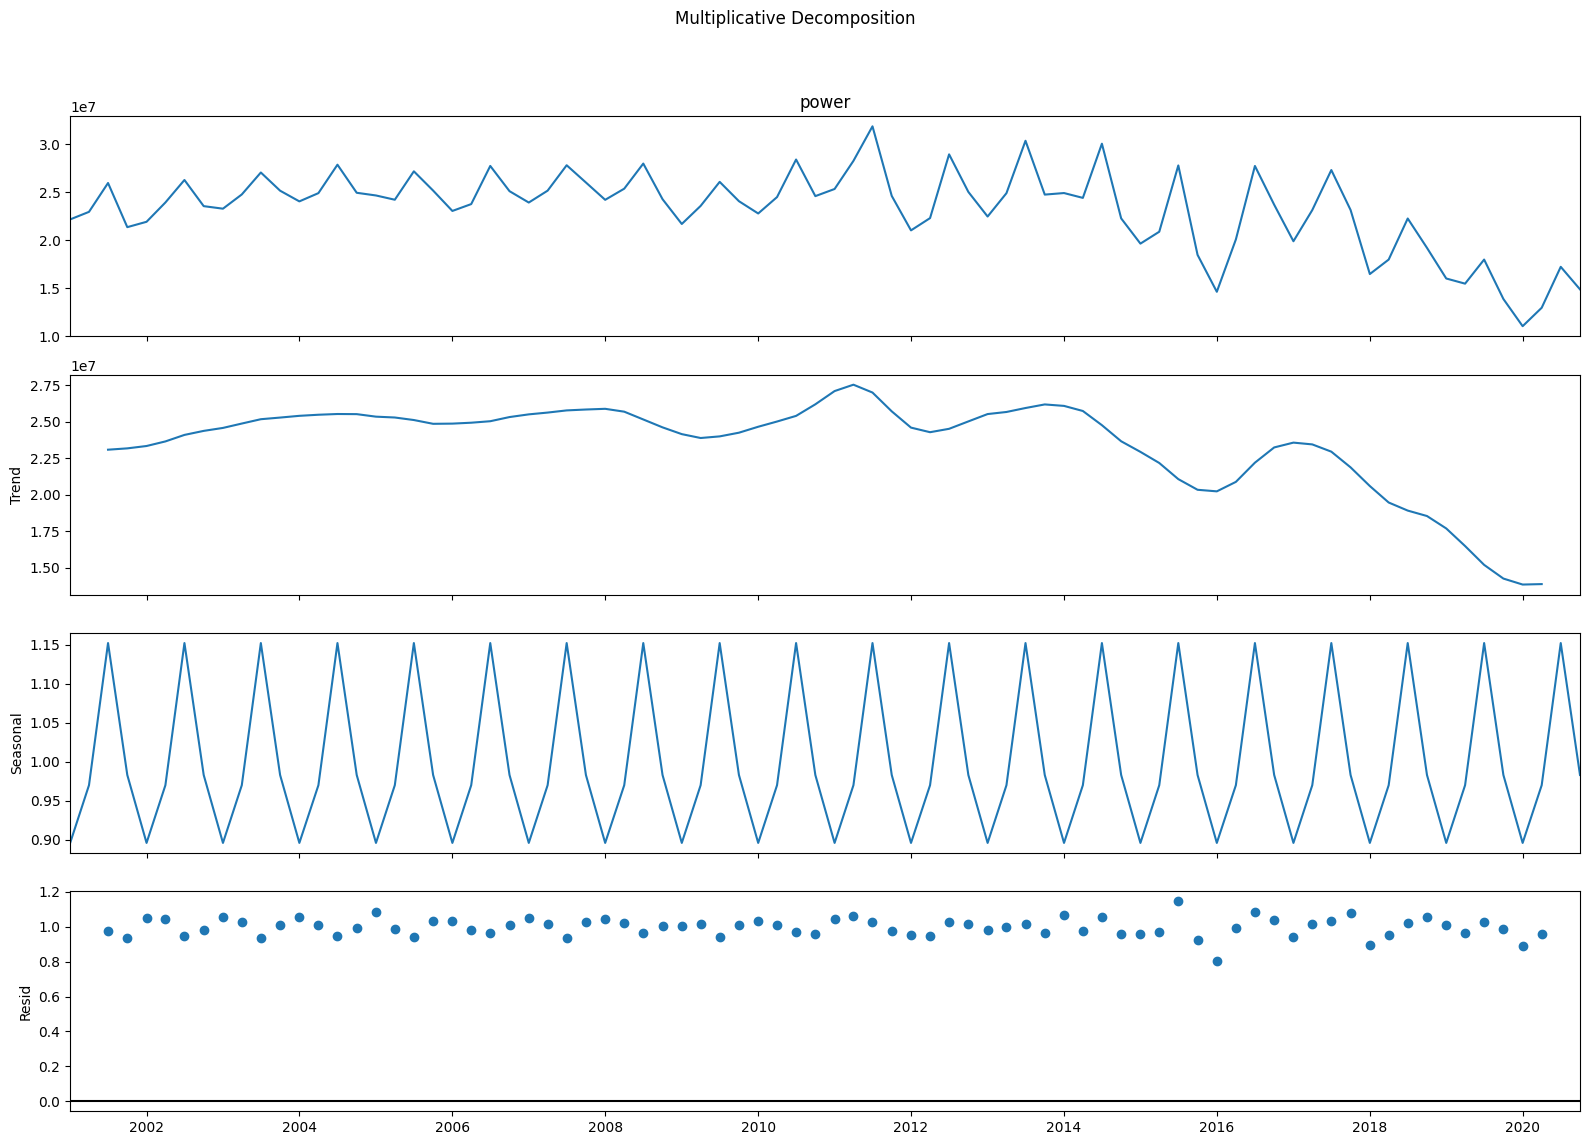

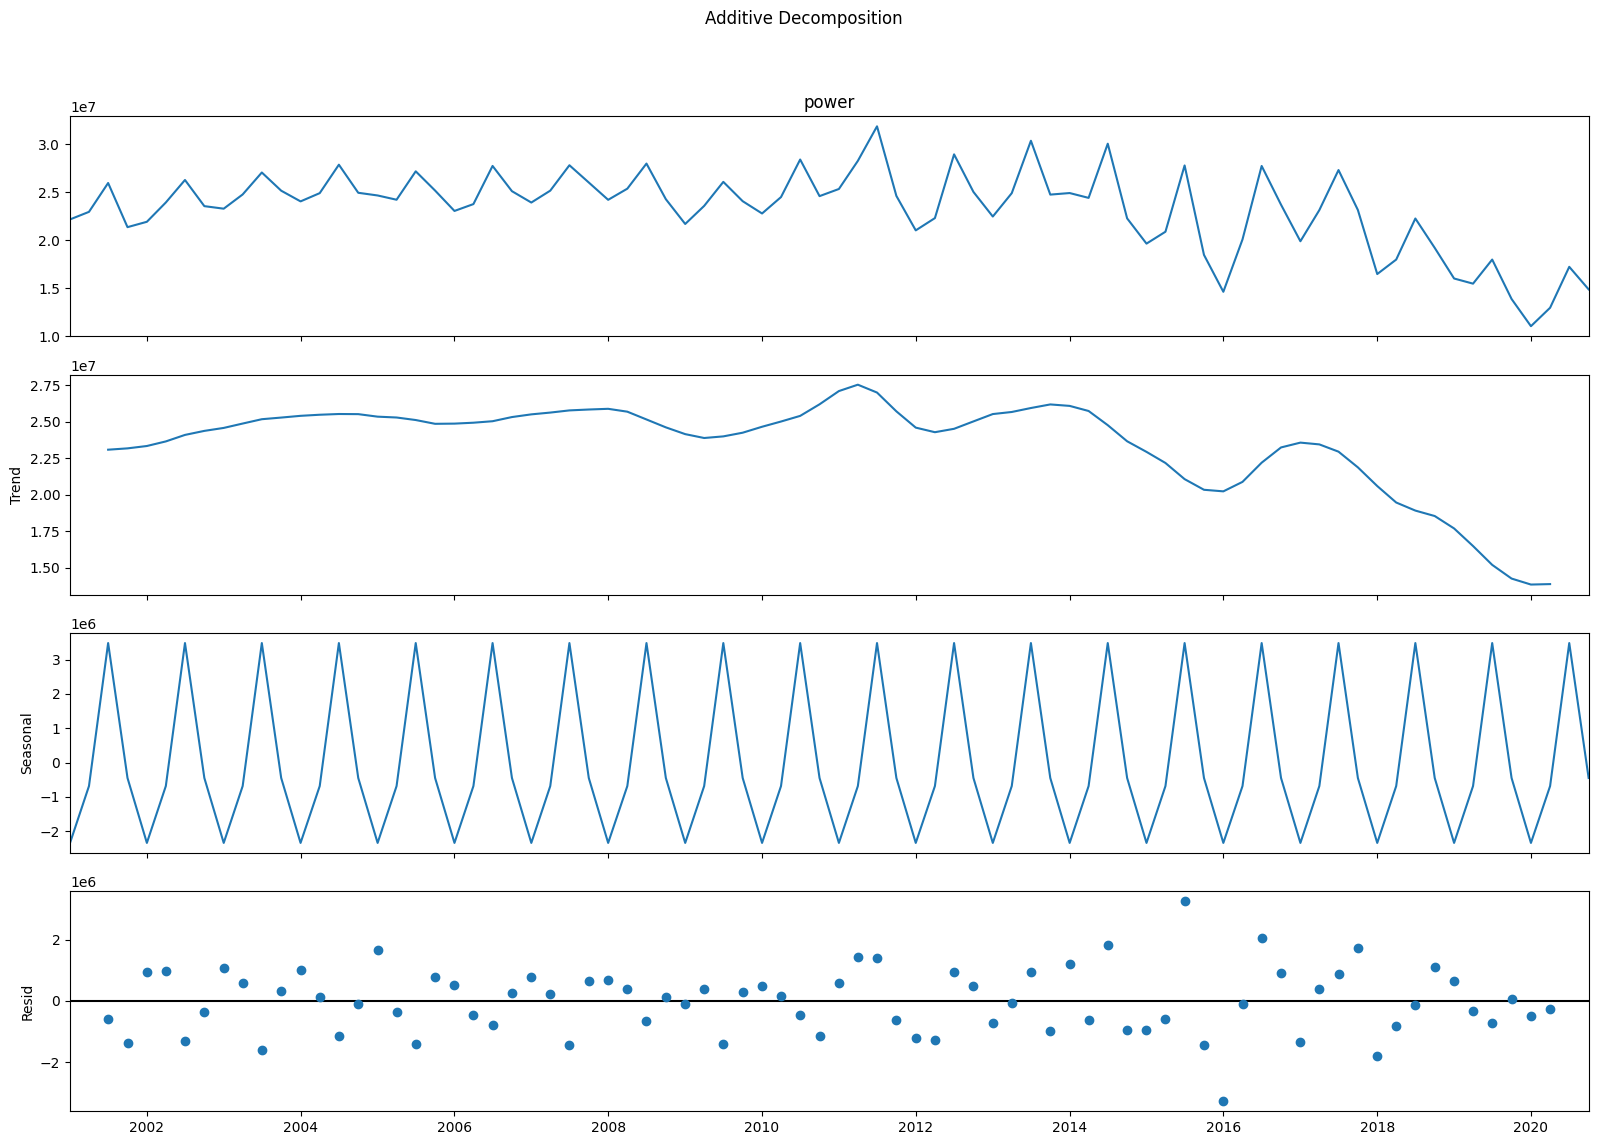

In [163]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse


# Multiplicative Decomposition 
multiplicative_decomposition = seasonal_decompose(CP['power'], model='multiplicative', period=4)

# Additive Decomposition
additive_decomposition = seasonal_decompose(CP['power'], model='additive', period=4)

# Plot
plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

additive_decomposition.plot().suptitle('Additive Decomposition')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()


### Seasonal Decomposition

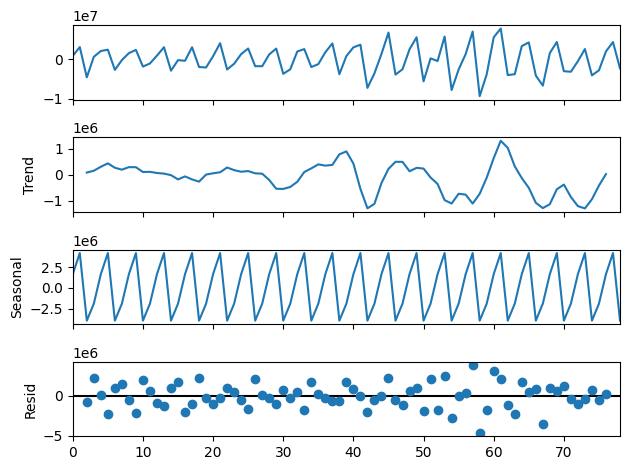

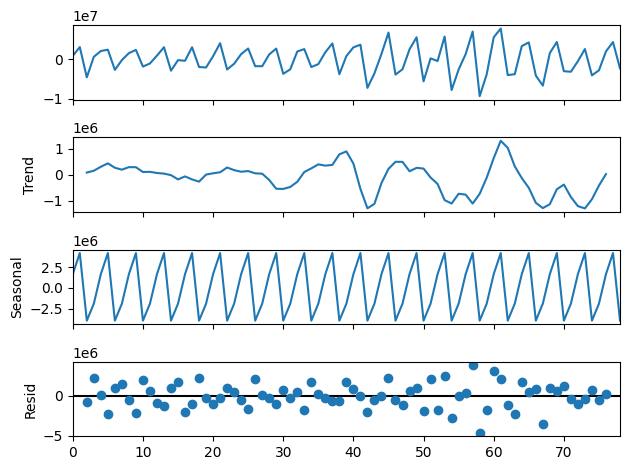

In [135]:
decompose_cp = seasonal_decompose(CP_diff, model = 'additive', period = 4)
decompose_cp.plot()

 The decomposition suggests that the time series data has a clear seasonal pattern that repeats on an annual basis, as expected for quarterly data. The trend component does not show any pronounced long-term upward or downward direction but does exhibit some variability that might correspond to multi-year cycles or other non-seasonal influences on coal power consumption. The relatively patternless residuals indicate a good fit of the model to the data, suggesting that the additive model with a period of 4 is appropriate for this time series.



### Checking for the presence of autocorrelation

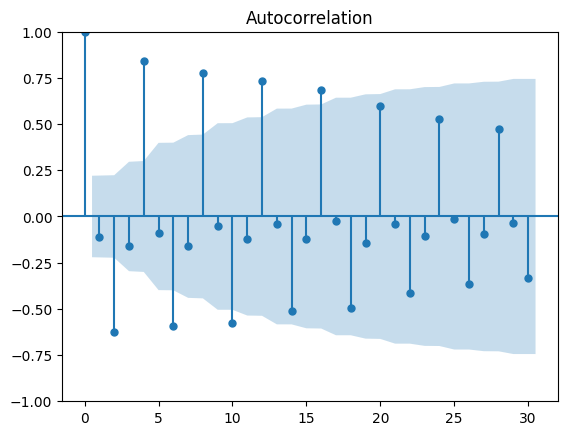

In [87]:
sm.graphics.tsa.plot_acf(CP_diff ,lags=30)
plt.show()

#####  The ACF plot indicates that the coal power consumption or generation data has a pronounced seasonal pattern, as evidenced by significant autocorrelations at the annual seasonal lags of 4, 8, 12, etc. This pattern is typical for energy consumption data, which often reflects higher or lower usage in specific seasons due to factors like heating and cooling needs.

##### Specifically, the autocorrelation at lag 4 being significant means that there's a strong correlation between a quarter and the same quarter in the following year. This suggests that whatever patterns or trends are occurring in coal power usage, they tend to repeat on an annual basis. The significant peaks at lags 8, 12 (and so on if the data continued) reinforce this yearly cycle, showing that the pattern is consistent over multiple years.


### Partial autocorrelation


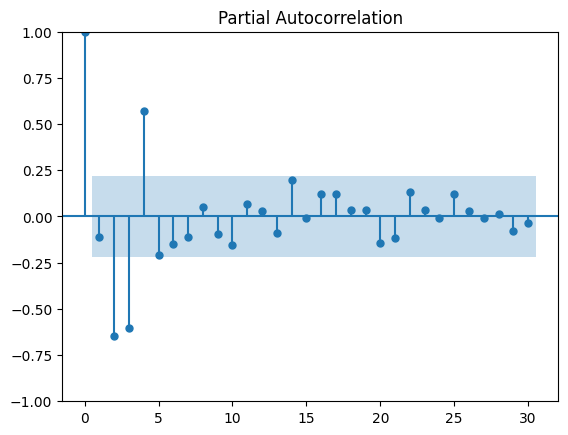

In [89]:
sm.graphics.tsa.plot_pacf(CP_diff ,lags=30, method="ywm")
plt.show()

### Split train and test data


In [158]:
if not isinstance(CP_diff, pd.Series):
    CP_diff = pd.Series(CP_diff.flatten())  

train_size = int(len(CP_diff) * 0.8)
cp_train = CP_diff.iloc[:train_size]
cp_test = CP_diff.iloc[train_size:]

### AR

In [159]:
lag_value = 4

ar_cp = AutoReg(cp_train, lags =lag_value).fit()
print (ar_cp.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                   63
Model:                     AutoReg(4)   Log Likelihood                -926.701
Method:               Conditional MLE   S.D. of innovations        1603766.319
Date:                Sun, 11 Feb 2024   AIC                           1865.403
Time:                        17:51:06   BIC                           1877.868
Sample:                             4   HQIC                          1870.269
                                   63                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.107e+04    2.1e+05      0.053      0.958   -4.01e+05    4.23e+05
y.L1          -0.2432      0.110     -2.203      0.028      -0.460      -0.027
y.L2          -0.3760      0.110     -3.404      0.0

### Prediction

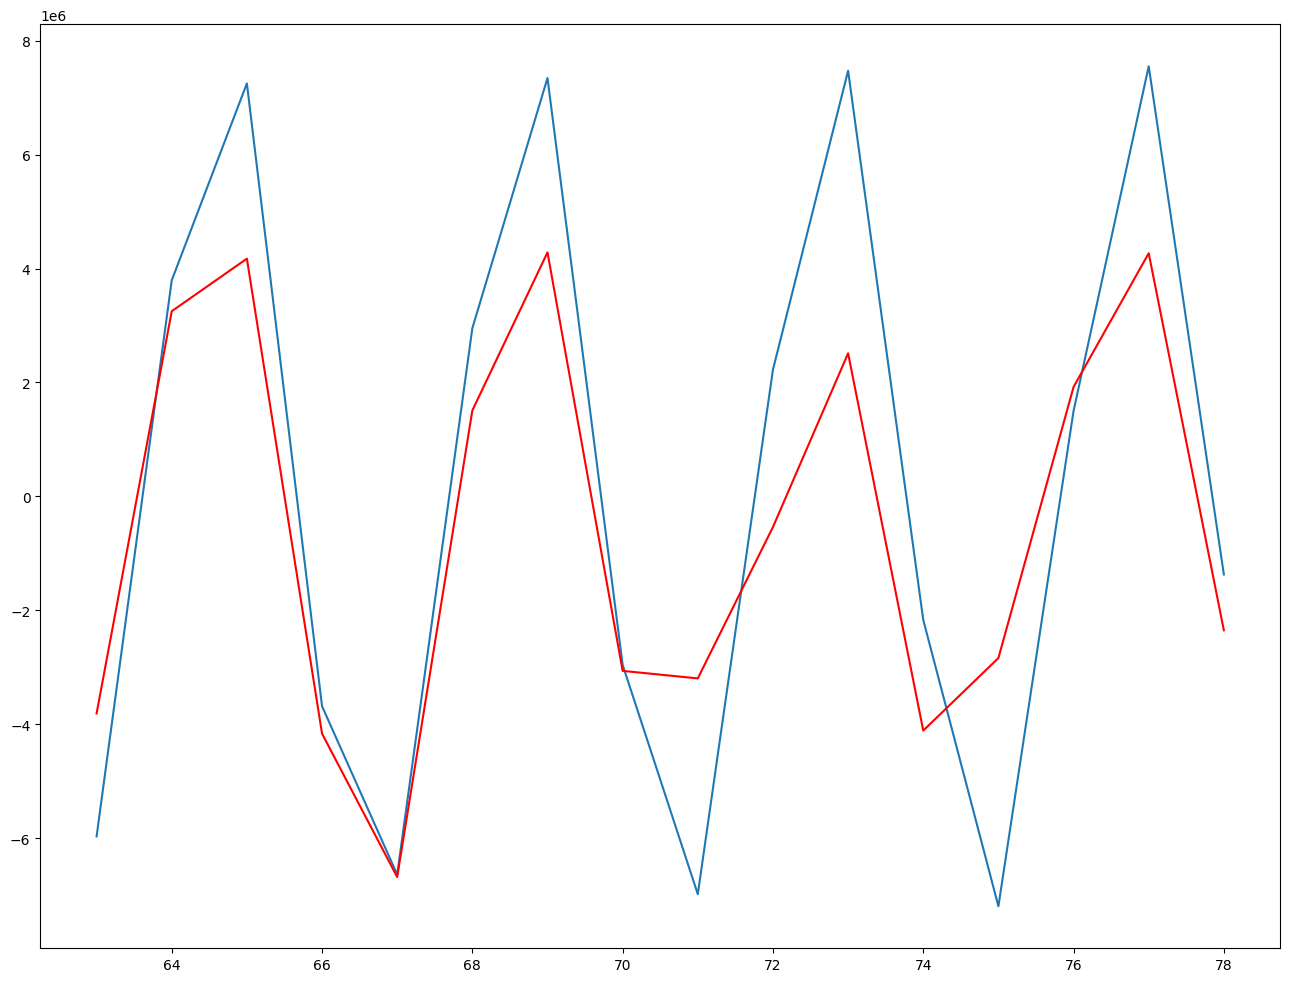

In [160]:
cp_pred = ar_cp.predict(start=len(cp_train), end=(len(CP_diff)-1), dynamic=False)
plt.figure()
plt.plot(cp_pred)
plt.plot(cp_test, color='red')

In [165]:
cp_pred_values = cp_pred.values.flatten() 
cp_test_values = cp_test.values.flatten() 

# Calculate Mean Squared Error
mse = mean_squared_error(cp_test_values, cp_pred_values)
print(f'Mean Squared Error: {mse}')

# Calculate Mean Absolute Error
mae = mean_absolute_error(cp_test_values, cp_pred_values)
print(f'Mean Absolute Error: {mae}')

# Calculate Mean Absolute Percentage Error
mape = np.mean(np.abs((cp_test_values - cp_pred_values) / cp_test_values)) * 100
print(f'Mean Absolute Percentage Error: {mape}%')


Mean Squared Error: 6711567592628.703
Mean Absolute Error: 2087892.8209137362
Mean Absolute Percentage Error: 93.81567566336686%


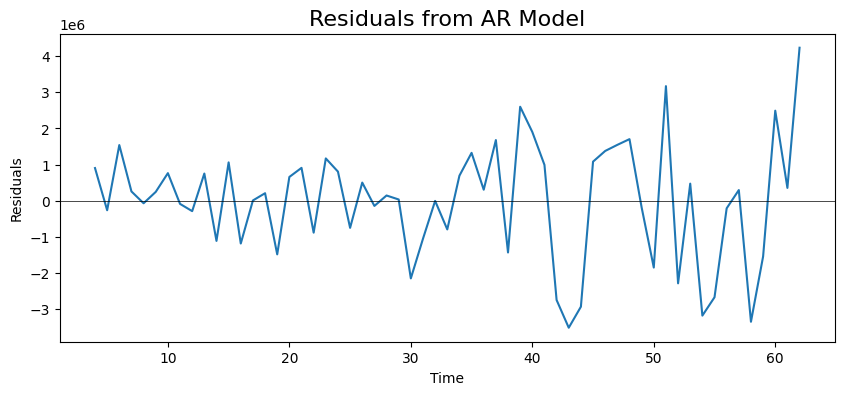

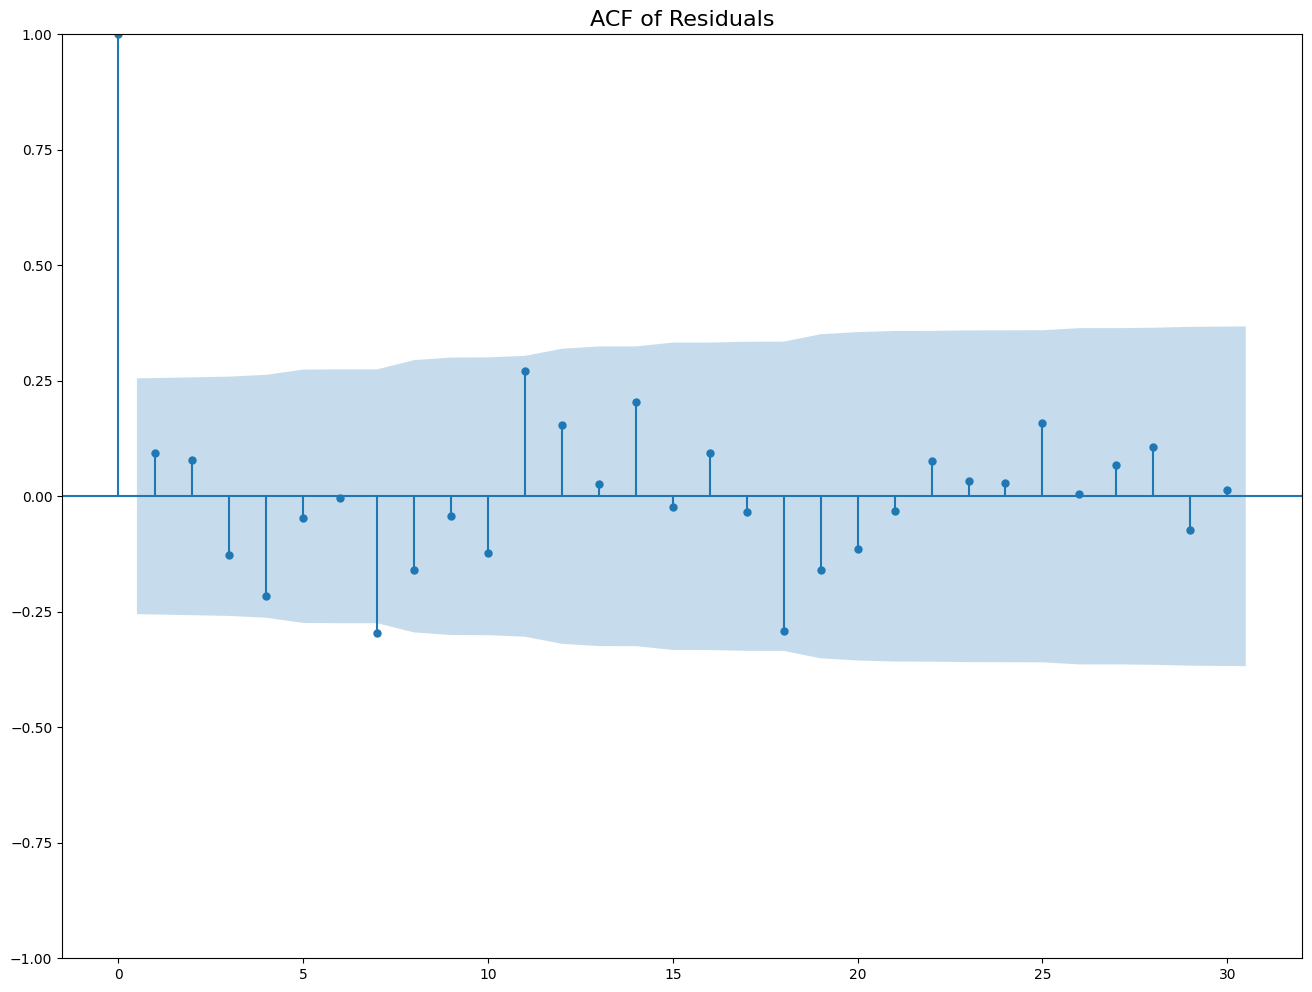

Statistic: 0.6986604786975754, p-Value: 0.7051602201621325
The residuals seem to be normally distributed (fail to reject H0 of normality).


In [166]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Calculate residuals
residuals = ar_cp.resid

# Plot residuals
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=16)
plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.show()

# Plot ACF of residuals
plot_acf(residuals, lags=30, alpha=0.05)
plt.title('ACF of Residuals', fontsize=16)
plt.show()

# Additionally, check for normality of residuals
from scipy.stats import normaltest

statistic, p_value = normaltest(residuals)
print(f'Statistic: {statistic}, p-Value: {p_value}')

# Interpret the normality test result
if p_value < 0.05:
    print("The residuals do not seem to be normally distributed (reject H0 of normality).")
else:
    print("The residuals seem to be normally distributed (fail to reject H0 of normality).")



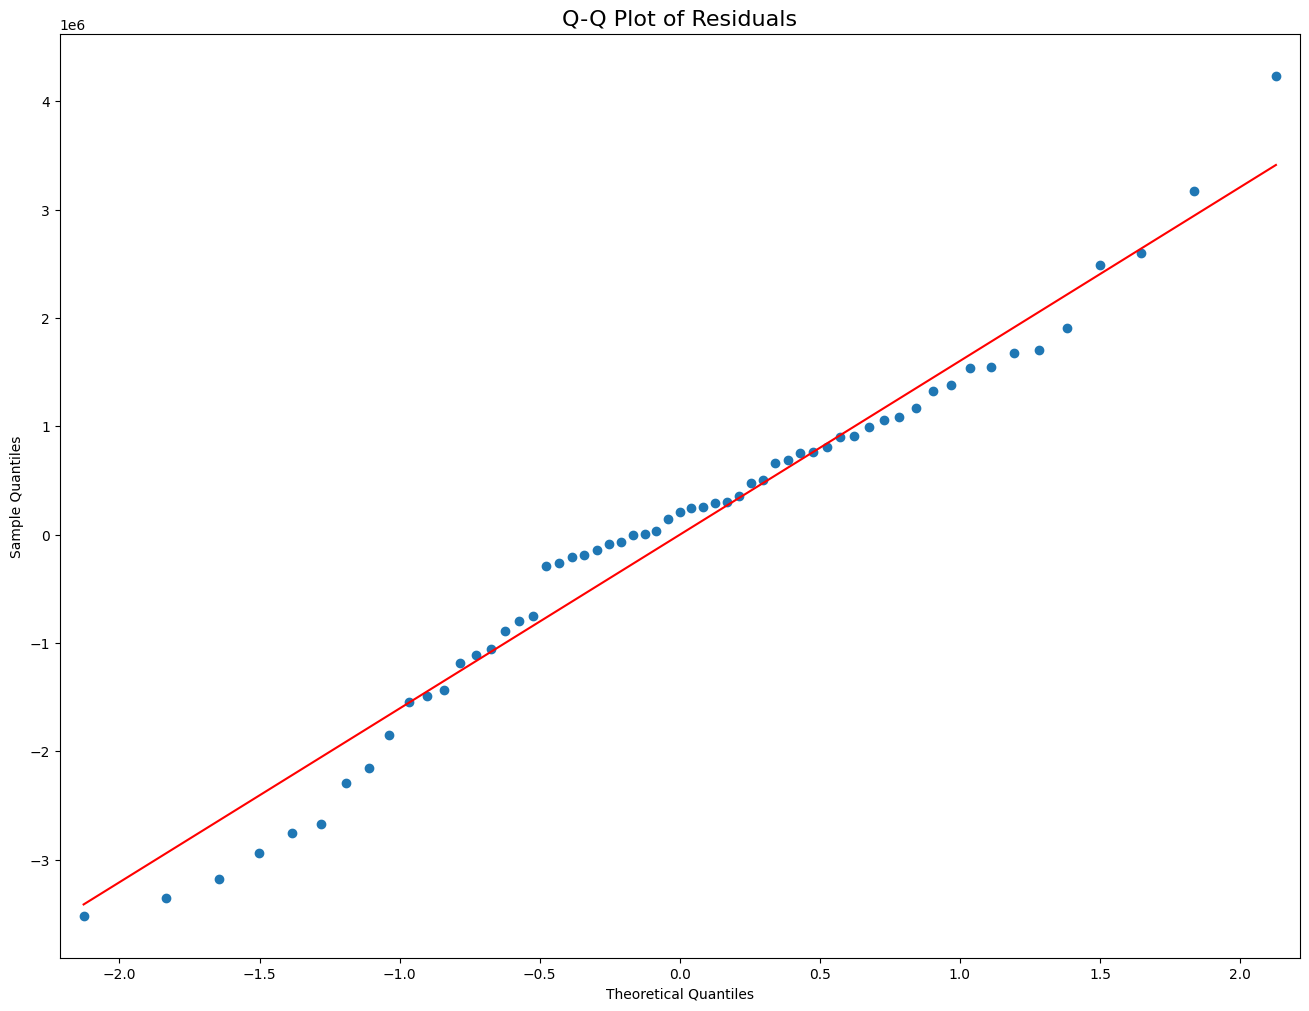

In [167]:
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals', fontsize=16)
plt.show()

## MA

In [170]:
ma_cp = ARIMA(cp_train, order=(0,0,3)).fit()
print(ma_cp.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   63
Model:                 ARIMA(0, 0, 4)   Log Likelihood               -1021.820
Date:                Sun, 11 Feb 2024   AIC                           2055.639
Time:                        18:03:20   BIC                           2068.498
Sample:                             0   HQIC                          2060.697
                                 - 63                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.434e+04   3.33e+05      0.073      0.942   -6.28e+05    6.77e+05
ma.L1         -0.1533      0.318     -0.482      0.630      -0.776       0.470
ma.L2         -0.6610      0.326     -2.028      0.0

/Users/maryamahmadi/Library/Python/3.10/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


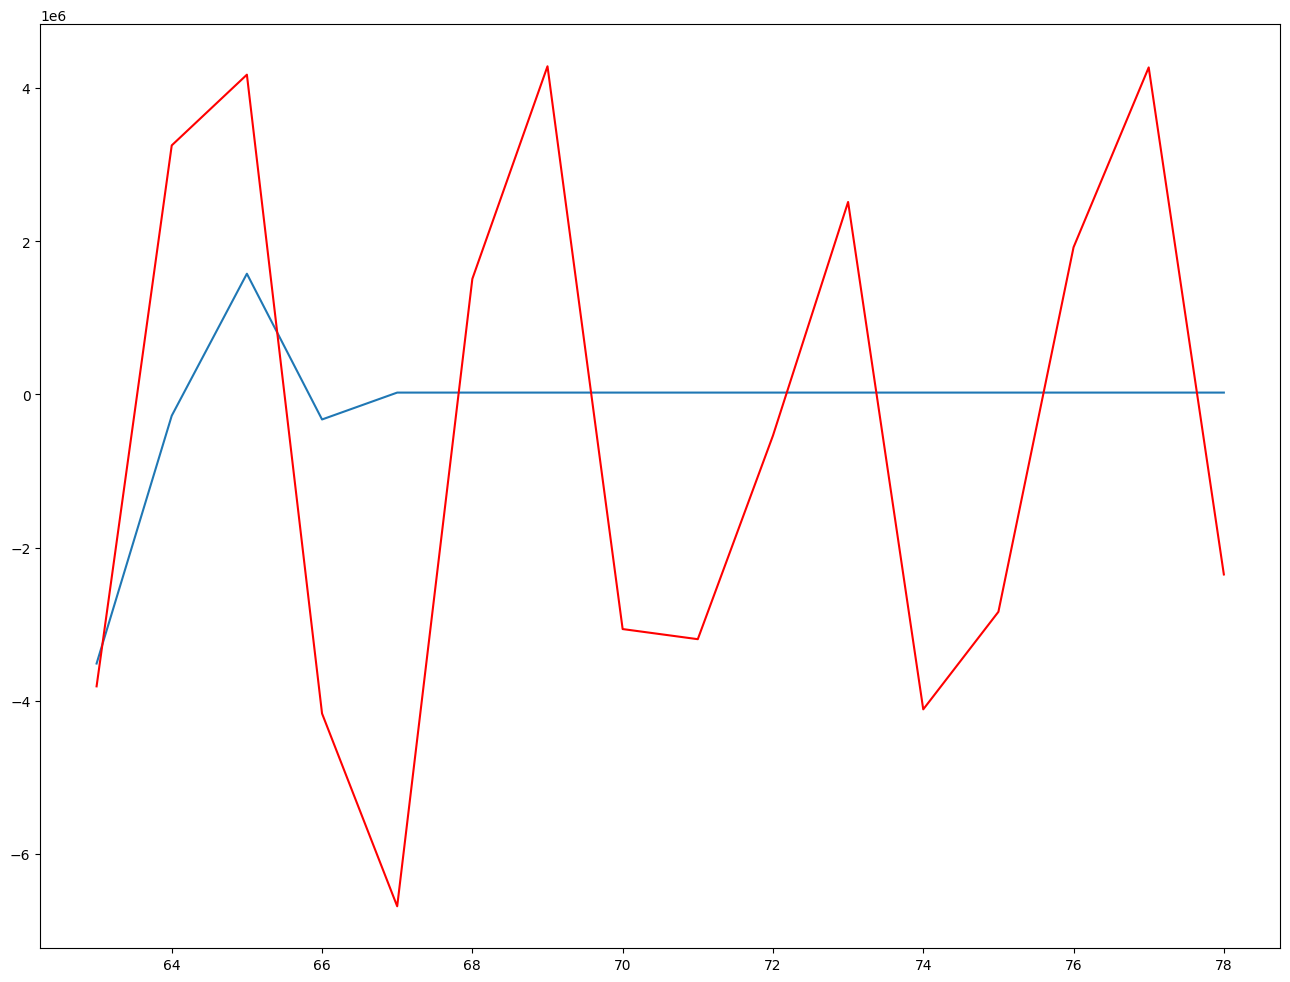

In [171]:
cp_pred = ma_cp.predict(start=len(cp_train), end=(len(CP_diff)-1), dynamic=False)
plt.figure()
plt.plot(cp_pred)
plt.plot(cp_test, color='red')

In [172]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming cp_pred contains the predictions and cp_test contains the actual test values
# Convert the predictions and actual values to the same format (e.g., numpy array) if they are not already
# This might involve flattening the pandas DataFrames or Series if they have multiple columns
cp_pred_values = cp_pred.values.flatten()  # Flatten if necessary
cp_test_values = cp_test.values.flatten()  # Flatten if necessary

# Calculate Mean Squared Error
mse = mean_squared_error(cp_test_values, cp_pred_values)
print(f'Mean Squared Error: {mse}')

# Calculate Mean Absolute Error
mae = mean_absolute_error(cp_test_values, cp_pred_values)
print(f'Mean Absolute Error: {mae}')

# Optionally, you can also calculate Mean Absolute Percentage Error
# Make sure to handle cases where the actual value is zero to avoid division by zero
mape = np.mean(np.abs((cp_test_values - cp_pred_values) / cp_test_values)) * 100
print(f'Mean Absolute Percentage Error: {mape}%')


Mean Squared Error: 11142298206256.943
Mean Absolute Error: 2973846.993878137
Mean Absolute Percentage Error: 92.16906184483986%


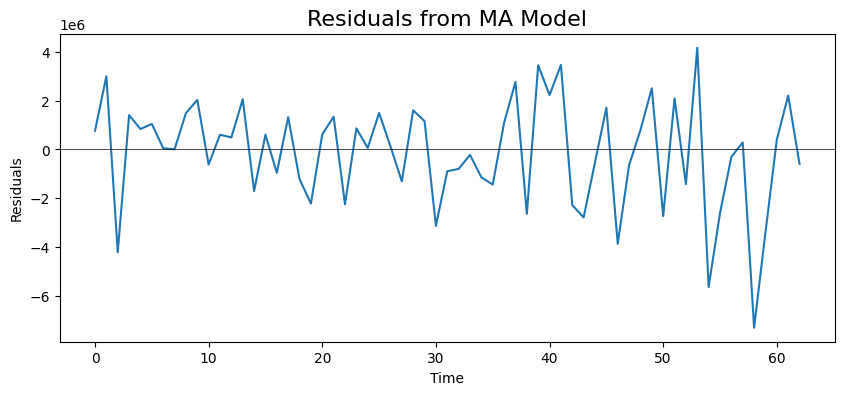

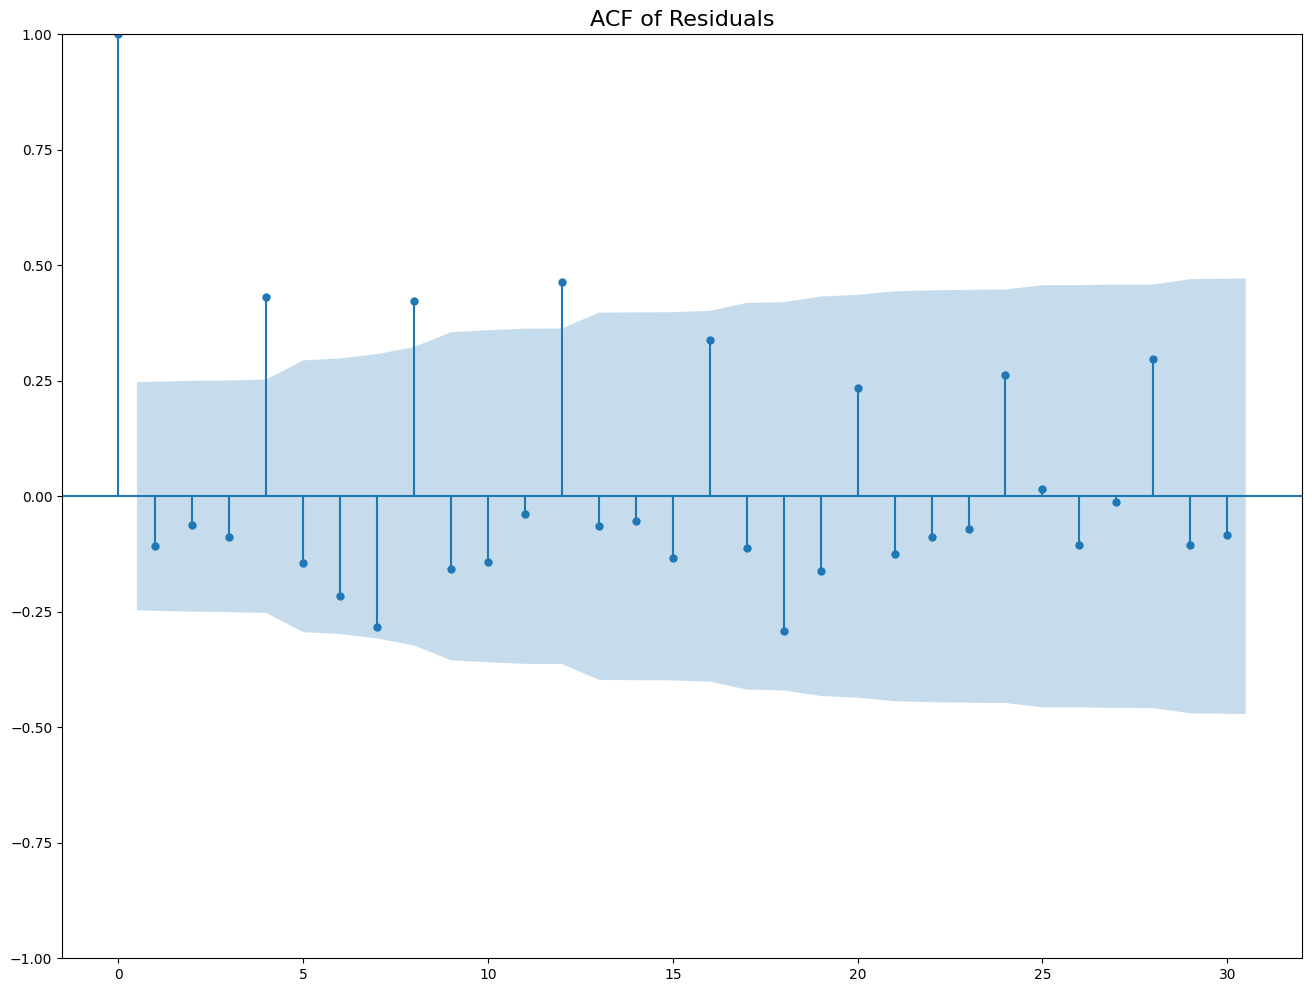

Statistic: 7.2691629086779095, p-Value: 0.026394979579980767
The residuals do not seem to be normally distributed (reject H0 of normality).


In [173]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Calculate residuals
residuals = ma_cp.resid

# Plot residuals
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('Residuals from MA Model', fontsize=16)
plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.show()

# Plot ACF of residuals
plot_acf(residuals, lags=30, alpha=0.05)
plt.title('ACF of Residuals', fontsize=16)
plt.show()

# Additionally, check for normality of residuals
from scipy.stats import normaltest

statistic, p_value = normaltest(residuals)
print(f'Statistic: {statistic}, p-Value: {p_value}')

# Interpret the normality test result
if p_value < 0.05:
    print("The residuals do not seem to be normally distributed (reject H0 of normality).")
else:
    print("The residuals seem to be normally distributed (fail to reject H0 of normality).")



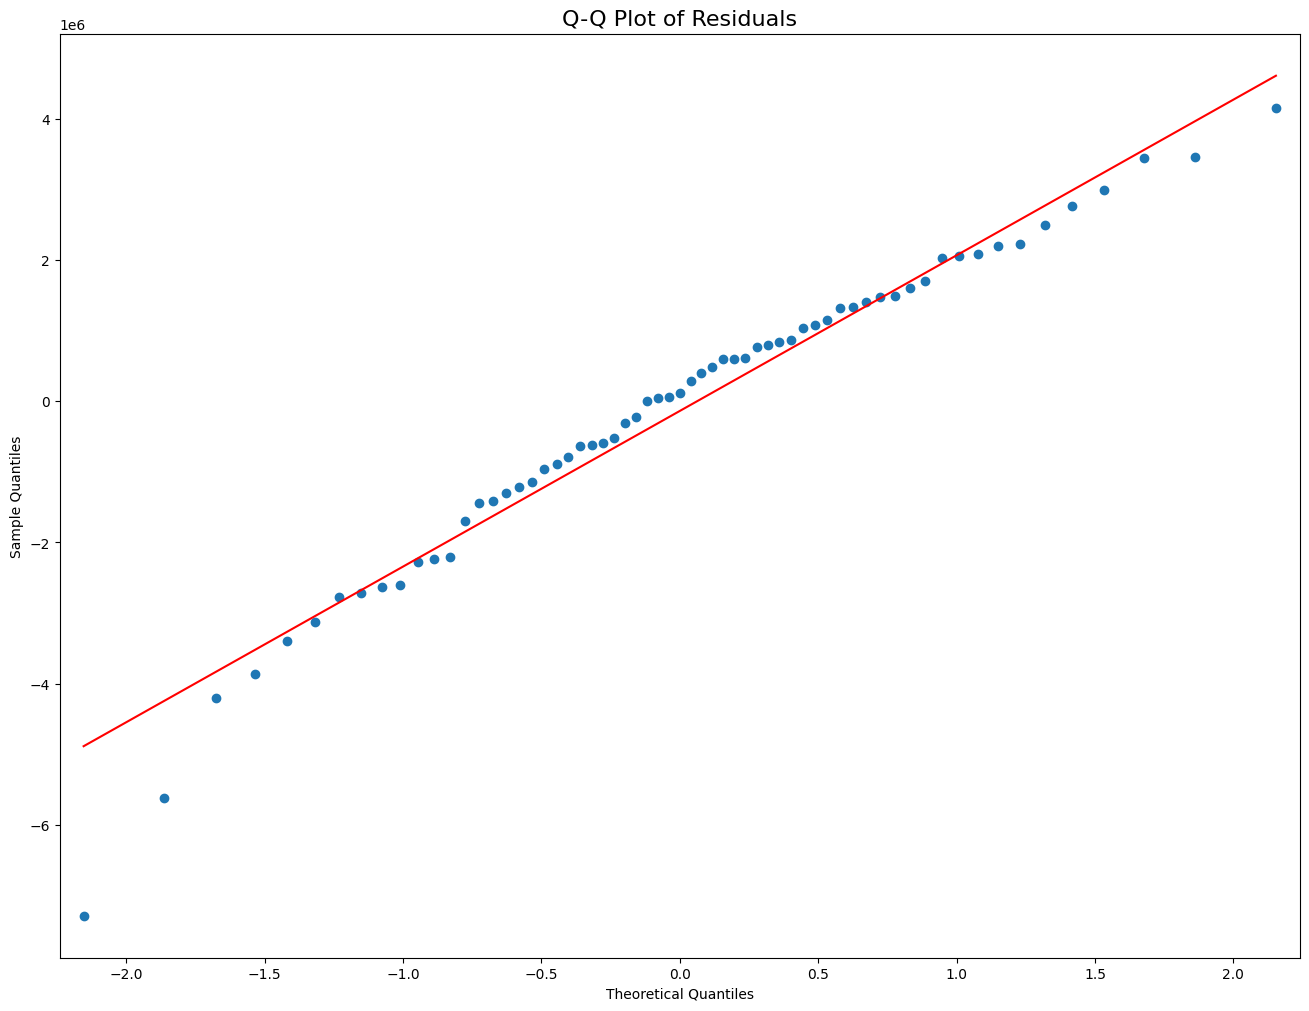

In [174]:
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals', fontsize=16)
plt.show()

### ARMA

In [132]:
arma_cp = ARIMA(cp_train, order=(2,0,1)).fit()
print(arma_cp.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   63
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -1020.388
Date:                Wed, 07 Feb 2024   AIC                           2050.777
Time:                        19:53:08   BIC                           2061.493
Sample:                             0   HQIC                          2054.991
                                 - 63                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.434e+04   6.17e+04      0.395      0.693   -9.65e+04    1.45e+05
ar.L1          0.0207      0.055      0.375      0.708      -0.088       0.129
ar.L2         -0.6551      0.069     -9.519      0.0

/Users/maryamahmadi/Library/Python/3.10/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


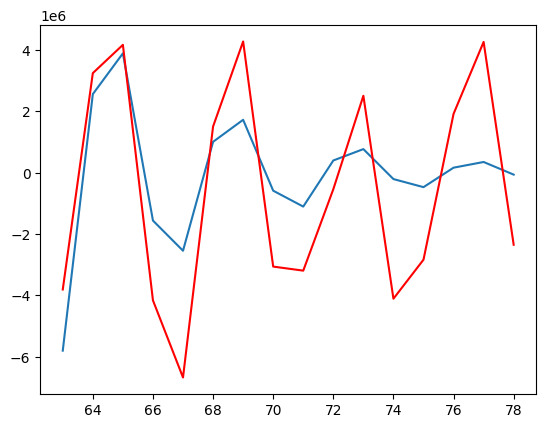

In [133]:
cp_pred = arma_cp.predict(start=len(cp_train), end=(len(CP_diff)-1), dynamic=False)
plt.figure()
plt.plot(cp_pred)
plt.plot(cp_test, color='red')

### ARIMA

In [106]:

train_size_cp_arima = int(len(CP)*0.8)
cp_train_arima = CP.iloc[:train_size_cp_arima, :]
cp_test_arima = CP.iloc[train_size_cp_arima:, :]

In [108]:
arima_cp = ARIMA(cp_train_arima, order=(2,1,1)).fit()
print(arima_cp.summary())

                               SARIMAX Results                                
Dep. Variable:                  power   No. Observations:                   64
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1051.093
Date:                Wed, 07 Feb 2024   AIC                           2110.185
Time:                        19:25:36   BIC                           2118.758
Sample:                    01-01-2001   HQIC                          2113.557
                         - 10-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1647      0.067      2.441      0.015       0.032       0.297
ar.L2         -0.3475      0.021    -16.509      0.000      -0.389      -0.306
ma.L1         -0.4647      0.089     -5.192      0.0

/Users/maryamahmadi/Library/Python/3.10/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/maryamahmadi/Library/Python/3.10/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/maryamahmadi/Library/Python/3.10/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/maryamahmadi/Library/Python/3.10/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


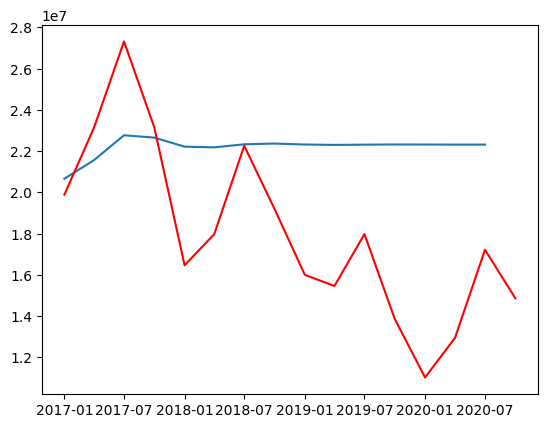

In [109]:
cp_pred = arima_cp.predict(start=len(cp_train_arima), end=(len(CP_diff)-1), dynamic=False)
plt.figure()
plt.plot(cp_pred)
plt.plot(cp_test_arima, color='red')